# Notebook to evaluate a trained model with pyfolio
Note: pyfolio must be install using pip install git+https://github.com/quantopian/pyfolio. There are known bugs with pip install pyfolio.

In [1]:
import os

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

from deep_rl_asset_allocation.configs import paths_config, data_config
from deep_rl_asset_allocation.utils import data_loader_utils

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# plotting in notebook
%matplotlib inline

### Helper Functions

In [4]:
def get_daily_return_as_df(df):
    df['daily_return'] = df.account_value.pct_change(1)
    # sharpe_ratio = (252**0.5) * df['daily_return'].mean() / df['daily_return'].std()
    # print(f'Sharpe Ratio: {sharpe_ratio*100:.2f} %')
    return df


def get_daily_return_as_series(df):
    df1 = df.copy()
    df1['Date'] = pd.to_datetime(df1['Date'])
    df1.set_index('Date', drop=False, inplace=True)
    df1.index = df1.index.tz_localize('UTC')
    del df1['Date']
    ts = pd.Series(df1['daily_return'].values, index=df1.index)
    return ts


def get_training_results_account_value(df_unique_trade_dates, results_csv_dir=paths_config.results_csv_dir):
    df_account_value = pd.DataFrame()
    for training_iteration, idx in enumerate(range(rebalance_window + validation_window, len(unique_trade_dates), rebalance_window)):
        asset_memory_csv_filename = os.path.join(results_csv_dir, f'total_asset_value_test_{training_iteration}.csv')
        df = pd.read_csv(asset_memory_csv_filename)
        df_account_value = df_account_value.append(df, ignore_index=True)
    # change the column name
    df_account_value = pd.DataFrame({'account_value': df_account_value['0']})
    # # get sharpe ratio
    # sharpe_ratio = (252**0.5) * df_account_value.account_value.pct_change(1).mean() / df_account_value.account_value.pct_change(1).std()
    # print(f'Sharpe Ratio: {sharpe_ratio*100:.2f} %')
    # merge with unique trade dates from 2016-01-04 or index 64
    df_account_value = df_account_value.join(df_unique_trade_dates.reset_index(drop=True))
    df_account_value = df_account_value[['date', 'account_value']]
    return df_account_value

### Benchmark: DJIA Index

In [5]:
# load DJIA - out of sample data (test data)
df_djia_out_of_sample = pd.read_csv(paths_config.TESTING_DATA_FILE)

In [6]:
# get data between dates
df_djia_out_of_sample = df_djia_out_of_sample[(df_djia_out_of_sample['Date'] >= str(data_config.TESTING_START)) & (df_djia_out_of_sample['Date'] <= str(data_config.TESTING_END))]
df_djia_out_of_sample = df_djia_out_of_sample.reset_index(drop=True)

# get daily return as relative difference in adjusted close price of DJIA
df_djia_out_of_sample['daily_return'] = df_djia_out_of_sample['Adj Close'].pct_change(1)
df_djia_out_of_sample = df_djia_out_of_sample.reset_index(drop=True).dropna()
df_djia_out_of_sample

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000,0.000567
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000,-0.014695
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000,-0.023211
4,2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000,-0.010152
5,2016-01-11,16358.709961,16461.849609,16232.030273,16398.570313,16398.570313,127790000,0.003188
...,...,...,...,...,...,...,...,...
1090,2020-05-04,23581.550781,23769.560547,23361.160156,23749.759766,23749.759766,355360000,0.001099
1091,2020-05-05,23958.880859,24169.720703,23868.910156,23883.089844,23883.089844,369710000,0.005614
1092,2020-05-06,23978.880859,24054.589844,23661.140625,23664.640625,23664.640625,377450000,-0.009147
1093,2020-05-07,23837.210938,24094.619141,23834.390625,23875.890625,23875.890625,369890000,0.008927


In [7]:
series_djia_out_of_sample = get_daily_return_as_series(df_djia_out_of_sample)
# series_djia_out_of_sample

### Benchmark: Min-variance

In [8]:
# read pkl file
df_min_variance = pd.read_pickle('zipline/benchmark_min_var.pkl').reset_index(drop=True)
df_min_variance

,period_open,period_close,capital_used,orders,net_leverage,gross_leverage,returns,long_exposure,pnl,longs_count,...,algo_volatility,max_leverage,treasury_period_return,alpha,beta,trading_days,excess_return,period_label,max_drawdown,weights
0,2016-01-04 14:31:00+00:00,2016-01-04 21:00:00+00:00,0.000000,[],0.000000,0.000000,0.000000,0.000,0.000000,0,...,NaN,0.000000,0.0,NaN,NaN,1,0.0,2016-01,0.000000,NaN
1,2016-01-05 14:31:00+00:00,2016-01-05 21:00:00+00:00,0.000000,[],0.000000,0.000000,0.000000,0.000,0.000000,0,...,0.000000,0.000000,0.0,0.000000,0.000000,2,0.0,2016-01,0.000000,NaN
2,2016-01-06 14:31:00+00:00,2016-01-06 21:00:00+00:00,0.000000,[],0.000000,0.000000,0.000000,0.000,0.000000,0,...,0.000000,0.000000,0.0,0.000000,0.000000,3,0.0,2016-01,0.000000,NaN
3,2016-01-07 14:31:00+00:00,2016-01-07 21:00:00+00:00,0.000000,[],0.000000,0.000000,0.000000,0.000,0.000000,0,...,0.000000,0.000000,0.0,0.000000,0.000000,4,0.0,2016-01,0.000000,NaN
4,2016-01-08 14:31:00+00:00,2016-01-08 21:00:00+00:00,0.000000,[],0.000000,0.000000,0.000000,0.000,0.000000,0,...,0.000000,0.000000,0.0,0.000000,0.000000,5,0.0,2016-01,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2020-05-01 13:31:00+00:00,2020-05-01 20:00:00+00:00,7856.698541,"[{'id': '65e6c4509d0e425a871d991e2e69ce79', 'd...",1.000070,1.000070,-0.009275,1529116.450,-14313.822459,7,...,0.154501,1.005661,0.0,0.049906,0.670646,1090,0.0,2020-05,-0.259338,"{Equity(0 [AAPL]): 0.0, Equity(1 [AXP]): 0.0, ..."
1090,2020-05-04 13:31:00+00:00,2020-05-04 20:00:00+00:00,0.000000,[],1.000070,1.000070,-0.006092,1519801.385,-9315.065000,7,...,0.154462,1.005661,0.0,0.048208,0.670616,1091,0.0,2020-05,-0.259338,"{Equity(0 [AAPL]): 0.0, Equity(1 [AXP]): 0.0, ..."
1091,2020-05-05 13:31:00+00:00,2020-05-05 20:00:00+00:00,0.000000,[],1.000070,1.000070,0.005047,1527471.612,7670.227000,7,...,0.154408,1.005661,0.0,0.048470,0.670649,1092,0.0,2020-05,-0.259338,"{Equity(0 [AAPL]): 0.0, Equity(1 [AXP]): 0.0, ..."
1092,2020-05-06 13:31:00+00:00,2020-05-06 20:00:00+00:00,0.000000,[],1.000071,1.000071,-0.013401,1507002.674,-20468.938000,7,...,0.154480,1.005661,0.0,0.046631,0.671056,1093,0.0,2020-05,-0.259338,"{Equity(0 [AAPL]): 0.0, Equity(1 [AXP]): 0.0, ..."


### RL: Training Results

In [9]:
# load Dow 30 - in sample data (training data)
df_djia_in_sample = data_loader_utils.load_preprocessed_djia_data()

# rebalance_window is the number of months to retrain the model
rebalance_window = data_config.REBALANCE_WINDOW
# validation_window is the number of months to validation the model and select for trading
validation_window = data_config.VALIDATION_WINDOW

# get unique trade dates to load model results
unique_trade_dates = data_loader_utils.get_data_between_dates(df_djia_in_sample, start=data_config.VALIDATION_START, end=data_config.TESTING_END).date.unique()
df_unique_trade_dates = pd.DataFrame({'date': unique_trade_dates})

# filter for when Testing Starts
df_unique_trade_dates = df_unique_trade_dates[df_unique_trade_dates.date >= str(data_config.TESTING_START)]
df_unique_trade_dates.index = df_unique_trade_dates.date.factorize()[0]
# df_unique_trade_dates

Found prevouisly saved pre-processed data: /Users/Aidan.Keaveny/git/deep-rl-asset-allocation/deep_rl_asset_allocation/data/csv/preprocessed_djia_data.csv


In [10]:
results_dir = os.path.join(paths_config.parent_dir, 'results')
results_csv_dir = os.path.join(results_dir, 'csv')

df_training_results_account_value = get_training_results_account_value(df_unique_trade_dates, results_csv_dir)
# df_training_results_account_value.account_value.plot()
# df_training_results_account_value

In [11]:
# get daily return as relative difference in account value
df_training_results_account_value['daily_return'] = df_training_results_account_value.account_value.pct_change(1)

# compare dates with test date
df_training_results_account_value['Date'] = df_djia_out_of_sample['Date']
df_training_results_account_value = df_training_results_account_value[['date', 'Date', 'account_value', 'daily_return']]

df_training_results_account_value = df_training_results_account_value.reset_index(drop=True).dropna()
df_training_results_account_value

,date,Date,account_value,daily_return
1,2016-01-05,2016-01-05,9.995243e+05,-0.000476
2,2016-01-06,2016-01-06,9.966794e+05,-0.002846
3,2016-01-07,2016-01-07,9.914018e+05,-0.005295
4,2016-01-08,2016-01-08,9.882176e+05,-0.003212
5,2016-01-11,2016-01-11,9.893211e+05,0.001117
...,...,...,...,...
1066,2020-03-30,2020-03-30,1.746872e+06,0.000000
1067,2020-03-31,2020-03-31,1.746872e+06,0.000000
1068,2020-04-01,2020-04-01,1.746872e+06,0.000000
1069,2020-04-02,2020-04-02,1.746872e+06,0.000000


In [12]:
series_training_results_account_value = get_daily_return_as_series(df_training_results_account_value)  # [0:1097]
# series_training_results_account_value

### Plot results

In [13]:
def convert_datadate_to_datetime(df):
    date_as_str = str(df['Date'])
    # output is '2009-01-02'
    year, month, day = str(date_as_str[:4]), str(date_as_str[5:7]), str(date_as_str[8:10])
    return pd.Timestamp(year=int(year), month=int(month), day=int(day))

In [14]:
dates = pd.date_range(data_config.TESTING_START, data_config.TESTING_END, freq='d')
df_dates = pd.DataFrame(index=dates, data=np.zeros(len(dates)), columns=['zeroes'])
type(df_dates.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [15]:
# df_min_variance["Date"] = df_min_variance["period_open"]
# str(df_min_variance["Date"][0])[8:10]

In [16]:
# df_training_results_account_value["Date"]

In [17]:
df_min_variance["Date"] = df_min_variance["period_open"]

df_djia_out_of_sample["Date"] = df_djia_out_of_sample.apply(convert_datadate_to_datetime, axis=1)
df_min_variance["Date"] = df_min_variance.apply(convert_datadate_to_datetime, axis=1)
df_training_results_account_value["Date"]= df_training_results_account_value.apply(convert_datadate_to_datetime, axis=1)

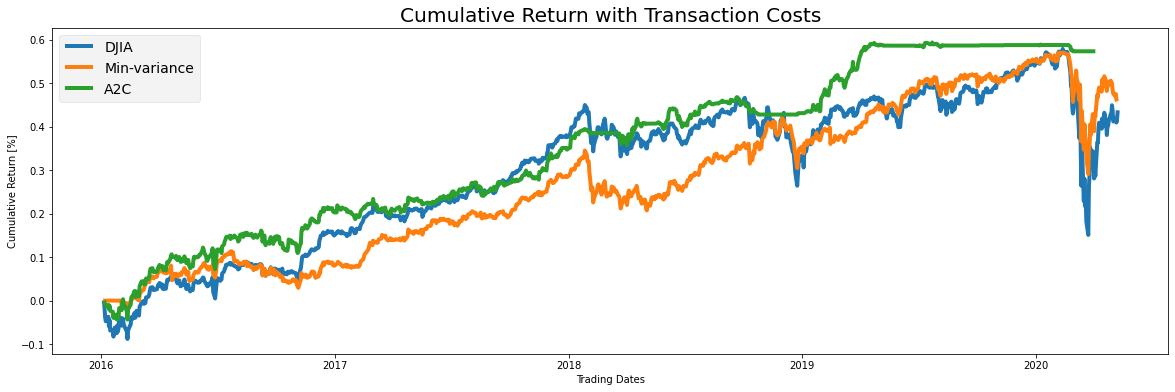

In [18]:
# init the plot
fig, ax = plt.subplots(figsize=(20, 6))
plt.style.use("fivethirtyeight")

ax.set(xlabel="Trading Dates",
       ylabel="Cumulative Return [%]",
       title="Cumulative Return with Transaction Costs",
       )

# init plot
# ax.plot(df_dates.index, df_dates.zeroes, alpha=0.01)

# plot actual data
ax.plot(df_djia_out_of_sample["Date"], df_djia_out_of_sample["daily_return"].cumsum(), label="DJIA")
ax.plot(df_min_variance["Date"], df_min_variance["returns"].cumsum(), label="Min-variance")
ax.plot(df_training_results_account_value["Date"], df_training_results_account_value["daily_return"].cumsum(), label="A2C")

# format plot
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))

# ax.set_xlim([pd.Timestamp(year=2015, month=6, day=1), pd.Timestamp(year=2021, month=1, day=1)])
plt.legend(loc='upper left')